# DQN


### Training of DQN in Tensorflow
--------------------------

In [1]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- closing: 5
- greeting: 4
- welcome: 8
- inform: 1
- deny: 9


### slot set

In [3]:
#
slots_set_path = "./data/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 29
Sample of dict:
- genre: 8
- actress: 1
- zip: 25
- ticket: 27
- critic_rating: 4


### movie dic: info about movie

In [4]:
#
movie_kb_path = "./data/movie_kb.1k.p"
movie_kb = pickle.load(open(movie_kb_path, 'rb'), encoding="latin")
sample_dict(movie_kb, sample_size=1)

keys = 991
Sample of dict:
- 142: {'date': 'saturday', 'city': 'seattle', 'moviename': 'zootopia', 'distanceconstraints': 'east side', 'theater': 'many', 'starttime': 'around 2pm'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./data/nlg/dia_act_nl_pairs.v6.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

write_model_dir: .\checkpoints\template\07102016\
eva_metric: 2
learning_rate: 0.001
sdgtype: rmsprop
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv
activation_func: relu
momentum: 0.1
reg_cost: 0.001
batch_size: 16
feed_recurrence: 0
max_epochs: 200
trained_model_path: None
model: lstm_tanh
split_method: 1
valid_test: 0
grad_clip: -0.0001
check_point: 20
cv_fold: 6
slot_rep: 1
hidden_size: 100
save_check_point: 20
smooth_eps: 1e-08
act_set: data/dia_acts.txt
pretrained_model_path: None
slot_set: data/slot_set.txt
dia_slot_val: 2
decay_rate: 0.999
init_rnn: 0


# User Simulator
-------------------

### goal

In [7]:
#
goal_file_path = './data/user_goals_first_turn_template.part.movie.v1.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'inform_slots': {'date': 'today', 'city': 'birmingham', 'moviename': 'zootopia', 'state': 'al', 'theater': 'carmike summit 16', 'numberofpeople': '1', 'starttime': 'around 2pm'}, 'diaact': 'request', 'request_slots': {}}


### Split goal set

In [8]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [9]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a movie dictionary for user simulator - slot:possible values

In [10]:
#
movie_dict_path = './data/user/dicts.v3.p'
movie_dictionary = pickle.load(open(movie_dict_path, 'rb'), encoding="latin")
samples = sample_dict(movie_dictionary, sample_size=1)

keys = 20
Sample of dict:
- numberofkids: ['two', '2', '1', 'no']


###  Create a User

In [11]:
user = RuleSimulator(movie_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [12]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [13]:

# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agt = 10
agent_params['batch_size']  = batch_size
if agt == 9:
    agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
else:
    agent = DQNAgentTF(movie_kb, act_set, slot_set, agent_params)

agent.set_nlg_model(nlg_model)

agent_run_mode:3
16


# Dialog Manager
-------------------

In [14]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, movie_kb)

## Running Episodes
-------------------

### Param

In [15]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 120
# num_episodes = 60

In [16]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [17]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [18]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt >= 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("----------------- Episode: %s ----------------- " % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            loss = agent.train(batch_size, 1)
            if agt == 10: 
                agent.model.update_target_params()
            else: 
                agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        losses.append(loss)
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [20]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
losses = []
agent.warm_start = 1
run_episodes(500, status)

warm_start starting ...
Warm_Start 120 epochs, success rate 0.47, ave reward 0.0, ave turns 19.2
Current experience replay buffer size 1190
warm_start finished, start RL training ...
----------------- Episode: 0 ----------------- 
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 3311
- cur bellman err 11.1066, experience replay pool 3311
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 1 / 500, Success rate: 0 / 1 Avg reward: -60.00 Avg turns: 42.00
----------------- Episode: 1 ----------------- 
simulation success rate 0.0, ave reward -40.87, ave turns 3.74
Train on : 3498
- cur bellman err 12.8224, experience replay pool 3498
Simulation success rate 0.0, Ave reward -40.87, Ave turns 3.74, Best success rate 0
Progress: 2 / 500, Success rate: 0 / 2 Avg reward: -50.50 Avg turns: 23.00
----------------- Episode: 2 ----------------- 
simulation success rate 0.0, ave reward -57.76, ave turns 37.52
Train on : 5374
- cur bel

- cur bellman err 8.2243, experience replay pool 48999
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 24 / 500, Success rate: 0 / 24 Avg reward: -59.21 Avg turns: 40.42
----------------- Episode: 24 ----------------- 
simulation success rate 0.0, ave reward -56.7, ave turns 35.4
Train on : 50769
- cur bellman err 6.2398, experience replay pool 50769
Simulation success rate 0.0, Ave reward -56.7, Ave turns 35.4, Best success rate 0
Progress: 25 / 500, Success rate: 0 / 25 Avg reward: -59.24 Avg turns: 40.48
----------------- Episode: 25 ----------------- 
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 52869
- cur bellman err 3.0709, experience replay pool 52869
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 26 / 500, Success rate: 0 / 26 Avg reward: -59.27 Avg turns: 40.54
----------------- Episode: 26 ----------------- 
simulation success rate 0.0, ave reward -60.0, ave

simulation success rate 0.47, ave reward 4.1, ave turns 26.6
simulation success rate 0.46, ave reward 2.95, ave turns 26.5
Train on : 1325
- cur bellman err 5.8728, experience replay pool 1325
Simulation success rate 0.47, Ave reward 4.1, Ave turns 26.6, Best success rate 0
Progress: 46 / 500, Success rate: 5 / 46 Avg reward: -44.96 Avg turns: 38.00
----------------- Episode: 46 ----------------- 
Successful Dialog!
simulation success rate 0.34, ave reward -12.86, ave turns 29.32
simulation success rate 0.45, ave reward 1.81, ave turns 26.38
Train on : 1319
- cur bellman err 6.5557, experience replay pool 1319
Simulation success rate 0.34, Ave reward -12.86, Ave turns 29.32, Best success rate 0
Progress: 47 / 500, Success rate: 6 / 47 Avg reward: -42.40 Avg turns: 37.45
----------------- Episode: 47 ----------------- 
Successful Dialog!
simulation success rate 0.43, ave reward -0.89, ave turns 26.98
simulation success rate 0.4, ave reward -4.3, ave turns 26.6
Train on : 1330
- cur bell

simulation success rate 0.34, ave reward -13.95, ave turns 31.5
simulation success rate 0.44, ave reward -0.41, ave turns 28.42
Train on : 1421
- cur bellman err 3.0459, experience replay pool 1421
Simulation success rate 0.34, Ave reward -13.95, Ave turns 31.5, Best success rate 0
Progress: 66 / 500, Success rate: 14 / 66 Avg reward: -31.18 Avg turns: 35.27
----------------- Episode: 66 ----------------- 
Successful Dialog!
simulation success rate 0.4, ave reward -5.91, ave turns 29.82
simulation success rate 0.35, ave reward -12.74, ave turns 31.48
Train on : 1574
- cur bellman err 2.8670, experience replay pool 1574
Simulation success rate 0.4, Ave reward -5.91, Ave turns 29.82, Best success rate 0
Progress: 67 / 500, Success rate: 15 / 67 Avg reward: -29.60 Avg turns: 34.93
----------------- Episode: 67 ----------------- 
simulation success rate 0.36, ave reward -11.41, ave turns 31.22
simulation success rate 0.35, ave reward -12.76, ave turns 31.52
Train on : 1576
- cur bellman er

simulation success rate 0.33, ave reward -15.32, ave turns 31.84
Train on : 1592
- cur bellman err 3.7498, experience replay pool 1592
Simulation success rate 0.39, Ave reward -7.1, Ave turns 29.8, Best success rate 0
Progress: 86 / 500, Success rate: 19 / 86 Avg reward: -30.05 Avg turns: 35.12
----------------- Episode: 86 ----------------- 
Successful Dialog!
simulation success rate 0.39, ave reward -7.07, ave turns 29.74
simulation success rate 0.41, ave reward -4.56, ave turns 29.52
Train on : 1476
- cur bellman err 2.9452, experience replay pool 1476
Simulation success rate 0.39, Ave reward -7.07, Ave turns 29.74, Best success rate 0
Progress: 87 / 500, Success rate: 20 / 87 Avg reward: -28.84 Avg turns: 34.85
----------------- Episode: 87 ----------------- 
Successful Dialog!
simulation success rate 0.41, ave reward -4.95, ave turns 30.3
simulation success rate 0.46, ave reward 1.76, ave turns 28.88
Train on : 1444
- cur bellman err 4.3496, experience replay pool 1444
Simulation 

simulation success rate 0.32, ave reward -16.7, ave turns 32.2
simulation success rate 0.3, ave reward -19.28, ave turns 32.56
Train on : 1628
- cur bellman err 3.0479, experience replay pool 1628
Simulation success rate 0.32, Ave reward -16.7, Ave turns 32.2, Best success rate 0
Progress: 107 / 500, Success rate: 25 / 107 Avg reward: -28.26 Avg turns: 34.60
----------------- Episode: 107 ----------------- 
simulation success rate 0.37, ave reward -9.4, ave turns 29.6
simulation success rate 0.33, ave reward -15.19, ave turns 31.58
Train on : 1579
- cur bellman err 3.0327, experience replay pool 1579
Simulation success rate 0.37, Ave reward -9.4, Ave turns 29.6, Best success rate 0
Progress: 108 / 500, Success rate: 25 / 108 Avg reward: -28.56 Avg turns: 34.67
----------------- Episode: 108 ----------------- 
simulation success rate 0.33, ave reward -15.03, ave turns 31.26
simulation success rate 0.36, ave reward -11.05, ave turns 30.5
Train on : 1525
- cur bellman err 2.8347, experien

simulation success rate 0.29, ave reward -20.39, ave turns 32.38
Train on : 3081
- cur bellman err 2.7776, experience replay pool 3081
Simulation success rate 0.29, Ave reward -20.39, Ave turns 32.38, Best success rate 0
Progress: 127 / 500, Success rate: 32 / 127 Avg reward: -25.82 Avg turns: 34.11
----------------- Episode: 127 ----------------- 
Successful Dialog!
simulation success rate 0.41, ave reward -4.52, ave turns 29.44
simulation success rate 0.28, ave reward -22.06, ave turns 33.32
Train on : 1666
- cur bellman err 6.4586, experience replay pool 1666
Simulation success rate 0.41, Ave reward -4.52, Ave turns 29.44, Best success rate 0
Progress: 128 / 500, Success rate: 33 / 128 Avg reward: -25.03 Avg turns: 33.94
----------------- Episode: 128 ----------------- 
simulation success rate 0.29, ave reward -20.84, ave turns 33.28
Train on : 3330
- cur bellman err 8.3733, experience replay pool 3330
Simulation success rate 0.29, Ave reward -20.84, Ave turns 33.28, Best success ra

simulation success rate 0.39, ave reward -7.69, ave turns 30.98
simulation success rate 0.42, ave reward -3.63, ave turns 30.06
Train on : 1503
- cur bellman err 6.4667, experience replay pool 1503
Simulation success rate 0.39, Ave reward -7.69, Ave turns 30.98, Best success rate 0
Progress: 147 / 500, Success rate: 37 / 147 Avg reward: -25.87 Avg turns: 34.15
----------------- Episode: 147 ----------------- 
Successful Dialog!
simulation success rate 0.39, ave reward -7.55, ave turns 30.7
simulation success rate 0.46, ave reward 1.83, ave turns 28.74
Train on : 1437
- cur bellman err 6.3335, experience replay pool 1437
Simulation success rate 0.39, Ave reward -7.55, Ave turns 30.7, Best success rate 0
Progress: 148 / 500, Success rate: 38 / 148 Avg reward: -25.18 Avg turns: 33.99
----------------- Episode: 148 ----------------- 
simulation success rate 0.49, ave reward 6.11, ave turns 27.38
simulation success rate 0.49, ave reward 5.93, ave turns 27.74
Train on : 1387
- cur bellman er

simulation success rate 0.49, ave reward 5.54, ave turns 28.52
simulation success rate 0.52, ave reward 9.65, ave turns 27.5
Train on : 1375
- cur bellman err 8.5827, experience replay pool 1375
Simulation success rate 0.49, Ave reward 5.54, Ave turns 28.52, Best success rate 0
Progress: 167 / 500, Success rate: 46 / 167 Avg reward: -22.76 Avg turns: 33.63
----------------- Episode: 167 ----------------- 
Successful Dialog!
simulation success rate 0.48, ave reward 5.16, ave turns 26.88
simulation success rate 0.51, ave reward 8.51, ave turns 27.38
Train on : 1369
- cur bellman err 7.5461, experience replay pool 1369
Simulation success rate 0.48, Ave reward 5.16, Ave turns 26.88, Best success rate 0
Progress: 168 / 500, Success rate: 47 / 168 Avg reward: -22.18 Avg turns: 33.51
----------------- Episode: 168 ----------------- 
Successful Dialog!
simulation success rate 0.6, ave reward 20.85, ave turns 24.3
simulation success rate 0.59, ave reward 19.21, ave turns 25.18
Train on : 1259
-

simulation success rate 0.6, ave reward 20.62, ave turns 24.76
Train on : 1238
- cur bellman err 18.3663, experience replay pool 1238
Simulation success rate 0.51, Ave reward 8.62, Ave turns 27.16, Best success rate 0
Progress: 187 / 500, Success rate: 57 / 187 Avg reward: -18.71 Avg turns: 32.57
----------------- Episode: 187 ----------------- 
Successful Dialog!
simulation success rate 0.43, ave reward -1.36, ave turns 27.92
simulation success rate 0.49, ave reward 6.17, ave turns 27.26
Train on : 1363
- cur bellman err 14.0944, experience replay pool 1363
Simulation success rate 0.43, Ave reward -1.36, Ave turns 27.92, Best success rate 0
Progress: 188 / 500, Success rate: 58 / 188 Avg reward: -18.22 Avg turns: 32.49
----------------- Episode: 188 ----------------- 
simulation success rate 0.52, ave reward 9.87, ave turns 27.06
simulation success rate 0.65, ave reward 27.27, ave turns 23.46
Train on : 1173
- cur bellman err 18.7714, experience replay pool 1173
Simulation success rat

Successful Dialog!
simulation success rate 0.5, ave reward 7.11, ave turns 27.78
simulation success rate 0.48, ave reward 4.94, ave turns 27.32
Train on : 1366
- cur bellman err 5.4324, experience replay pool 1366
Simulation success rate 0.5, Ave reward 7.11, Ave turns 27.78, Best success rate 0
Progress: 207 / 500, Success rate: 70 / 207 Avg reward: -14.29 Avg turns: 31.74
----------------- Episode: 207 ----------------- 
simulation success rate 0.47, ave reward 3.33, ave turns 28.14
simulation success rate 0.49, ave reward 6.43, ave turns 26.74
Train on : 1337
- cur bellman err 7.2185, experience replay pool 1337
Simulation success rate 0.47, Ave reward 3.33, Ave turns 28.14, Best success rate 0
Progress: 208 / 500, Success rate: 70 / 208 Avg reward: -14.51 Avg turns: 31.79
----------------- Episode: 208 ----------------- 
simulation success rate 0.46, ave reward 2.2, ave turns 28.0
simulation success rate 0.61, ave reward 22.14, ave turns 24.12
Train on : 1206
- cur bellman err 7.93

simulation success rate 0.5, ave reward 7.58, ave turns 26.84
simulation success rate 0.48, ave reward 5.32, ave turns 26.56
Train on : 1328
- cur bellman err 4.9094, experience replay pool 1328
Simulation success rate 0.5, Ave reward 7.58, Ave turns 26.84, Best success rate 0
Progress: 227 / 500, Success rate: 79 / 227 Avg reward: -12.89 Avg turns: 31.31
----------------- Episode: 227 ----------------- 
Successful Dialog!
simulation success rate 0.45, ave reward 1.04, ave turns 27.92
simulation success rate 0.5, ave reward 7.25, ave turns 27.5
Train on : 1375
- cur bellman err 3.9992, experience replay pool 1375
Simulation success rate 0.45, Ave reward 1.04, Ave turns 27.92, Best success rate 0
Progress: 228 / 500, Success rate: 80 / 228 Avg reward: -12.51 Avg turns: 31.23
----------------- Episode: 228 ----------------- 
Successful Dialog!
simulation success rate 0.54, ave reward 12.78, ave turns 26.04
simulation success rate 0.5, ave reward 7.2, ave turns 27.6
Train on : 1380
- cur 

Successful Dialog!
simulation success rate 0.46, ave reward 3.44, ave turns 25.52
simulation success rate 0.48, ave reward 5.79, ave turns 25.62
Train on : 1281
- cur bellman err 6.0503, experience replay pool 1281
Simulation success rate 0.46, Ave reward 3.44, Ave turns 25.52, Best success rate 0
Progress: 247 / 500, Success rate: 92 / 247 Avg reward: -9.64 Avg turns: 30.68
----------------- Episode: 247 ----------------- 
simulation success rate 0.44, ave reward 0.7, ave turns 26.2
simulation success rate 0.52, ave reward 11.42, ave turns 23.96
Train on : 1198
- cur bellman err 5.7731, experience replay pool 1198
Simulation success rate 0.44, Ave reward 0.7, Ave turns 26.2, Best success rate 0
Progress: 248 / 500, Success rate: 92 / 248 Avg reward: -9.85 Avg turns: 30.73
----------------- Episode: 248 ----------------- 
Successful Dialog!
simulation success rate 0.44, ave reward 0.56, ave turns 26.48
simulation success rate 0.33, ave reward -14.26, ave turns 29.72
Train on : 1486
- c

simulation success rate 0.45, ave reward 3.95, ave turns 22.1
simulation success rate 0.48, ave reward 8.05, ave turns 21.1
Train on : 1055
- cur bellman err 11.9535, experience replay pool 1055
Simulation success rate 0.45, Ave reward 3.95, Ave turns 22.1, Best success rate 0
Progress: 268 / 500, Success rate: 94 / 268 Avg reward: -12.35 Avg turns: 30.87
----------------- Episode: 268 ----------------- 
Successful Dialog!
simulation success rate 0.45, ave reward 3.75, ave turns 22.5
simulation success rate 0.45, ave reward 4.22, ave turns 21.56
Train on : 1078
- cur bellman err 12.9879, experience replay pool 1078
Simulation success rate 0.45, Ave reward 3.75, Ave turns 22.5, Best success rate 0
Progress: 269 / 500, Success rate: 95 / 269 Avg reward: -12.02 Avg turns: 30.80
----------------- Episode: 269 ----------------- 
simulation success rate 0.49, ave reward 8.76, ave turns 22.08
simulation success rate 0.32, ave reward -12.43, ave turns 23.66
Train on : 1183
- cur bellman err 13

simulation success rate 0.58, ave reward 19.09, ave turns 23.02
simulation success rate 0.63, ave reward 25.79, ave turns 21.62
Train on : 1081
- cur bellman err 10.8081, experience replay pool 1081
Simulation success rate 0.58, Ave reward 19.09, Ave turns 23.02, Best success rate 0
Progress: 288 / 500, Success rate: 103 / 288 Avg reward: -11.41 Avg turns: 30.66
----------------- Episode: 288 ----------------- 
Successful Dialog!
simulation success rate 0.67, ave reward 30.46, ave turns 21.88
simulation success rate 0.53, ave reward 11.91, ave turns 25.38
Train on : 1269
- cur bellman err 9.9037, experience replay pool 1269
Simulation success rate 0.67, Ave reward 30.46, Ave turns 21.88, Best success rate 0
Progress: 289 / 500, Success rate: 104 / 289 Avg reward: -11.11 Avg turns: 30.59
----------------- Episode: 289 ----------------- 
simulation success rate 0.59, ave reward 19.42, ave turns 24.76
simulation success rate 0.65, ave reward 27.97, ave turns 22.06
Train on : 1103
- cur be

Successful Dialog!
simulation success rate 0.81, ave reward 49.01, ave turns 18.38
simulation success rate 0.74, ave reward 40.13, ave turns 19.34
Train on : 967
- cur bellman err 8.3478, experience replay pool 967
Simulation success rate 0.81, Ave reward 49.01, Ave turns 18.38, Best success rate 0
Progress: 308 / 500, Success rate: 117 / 308 Avg reward: -8.43 Avg turns: 30.03
----------------- Episode: 308 ----------------- 
Successful Dialog!
simulation success rate 0.68, ave reward 31.62, ave turns 21.96
simulation success rate 0.7, ave reward 34.94, ave turns 20.12
Train on : 1006
- cur bellman err 7.3124, experience replay pool 1006
Simulation success rate 0.68, Ave reward 31.62, Ave turns 21.96, Best success rate 0
Progress: 309 / 500, Success rate: 118 / 309 Avg reward: -8.16 Avg turns: 29.97
----------------- Episode: 309 ----------------- 
Successful Dialog!
simulation success rate 0.74, ave reward 40.44, ave turns 18.72
simulation success rate 0.71, ave reward 36.24, ave turn

Successful Dialog!
simulation success rate 0.78, ave reward 45.02, ave turns 19.16
simulation success rate 0.73, ave reward 38.75, ave turns 19.7
Train on : 985
- cur bellman err 8.3877, experience replay pool 985
Simulation success rate 0.78, Ave reward 45.02, Ave turns 19.16, Best success rate 0
Progress: 328 / 500, Success rate: 132 / 328 Avg reward: -5.34 Avg turns: 29.27
----------------- Episode: 328 ----------------- 
simulation success rate 0.78, ave reward 45.49, ave turns 18.22
simulation success rate 0.78, ave reward 45.44, ave turns 18.32
Train on : 916
- cur bellman err 8.2289, experience replay pool 916
Simulation success rate 0.78, Ave reward 45.49, Ave turns 18.22, Best success rate 0
Progress: 329 / 500, Success rate: 132 / 329 Avg reward: -5.51 Avg turns: 29.31
----------------- Episode: 329 ----------------- 
Successful Dialog!
simulation success rate 0.79, ave reward 46.86, ave turns 17.88
simulation success rate 0.8, ave reward 48.39, ave turns 17.22
Train on : 861

simulation success rate 0.76, ave reward 42.94, ave turns 18.52
simulation success rate 0.79, ave reward 46.87, ave turns 17.86
Train on : 893
- cur bellman err 12.3425, experience replay pool 893
Simulation success rate 0.76, Ave reward 42.94, Ave turns 18.52, Best success rate 0
Progress: 348 / 500, Success rate: 144 / 348 Avg reward: -3.72 Avg turns: 28.76
----------------- Episode: 348 ----------------- 
Successful Dialog!
simulation success rate 0.71, ave reward 35.97, ave turns 20.46
simulation success rate 0.79, ave reward 46.41, ave turns 18.78
Train on : 939
- cur bellman err 9.9070, experience replay pool 939
Simulation success rate 0.71, Ave reward 35.97, Ave turns 20.46, Best success rate 0
Progress: 349 / 500, Success rate: 145 / 349 Avg reward: -3.50 Avg turns: 28.70
----------------- Episode: 349 ----------------- 
Successful Dialog!
simulation success rate 0.77, ave reward 44.24, ave turns 18.32
simulation success rate 0.76, ave reward 42.5, ave turns 19.4
Train on : 97

Successful Dialog!
simulation success rate 0.77, ave reward 43.73, ave turns 19.34
simulation success rate 0.65, ave reward 27.47, ave turns 23.06
Train on : 1153
- cur bellman err 9.9813, experience replay pool 1153
Simulation success rate 0.77, Ave reward 43.73, Ave turns 19.34, Best success rate 0
Progress: 368 / 500, Success rate: 158 / 368 Avg reward: -1.56 Avg turns: 28.16
----------------- Episode: 368 ----------------- 
Successful Dialog!
simulation success rate 0.72, ave reward 36.71, ave turns 21.38
simulation success rate 0.74, ave reward 39.26, ave turns 21.08
Train on : 1054
- cur bellman err 10.9244, experience replay pool 1054
Simulation success rate 0.72, Ave reward 36.71, Ave turns 21.38, Best success rate 0
Progress: 369 / 500, Success rate: 159 / 369 Avg reward: -1.36 Avg turns: 28.12
----------------- Episode: 369 ----------------- 
simulation success rate 0.83, ave reward 51.32, ave turns 18.56
simulation success rate 0.8, ave reward 47.34, ave turns 19.32
Train on

Successful Dialog!
simulation success rate 0.75, ave reward 42.69, ave turns 16.62
simulation success rate 0.77, ave reward 44.89, ave turns 17.02
Train on : 851
- cur bellman err 12.2319, experience replay pool 851
Simulation success rate 0.75, Ave reward 42.69, Ave turns 16.62, Best success rate 0
Progress: 388 / 500, Success rate: 175 / 388 Avg reward: 1.34 Avg turns: 27.57
----------------- Episode: 388 ----------------- 
Successful Dialog!
simulation success rate 0.75, ave reward 42.28, ave turns 17.44
simulation success rate 0.79, ave reward 47.61, ave turns 16.38
Train on : 819
- cur bellman err 14.9267, experience replay pool 819
Simulation success rate 0.75, Ave reward 42.28, Ave turns 17.44, Best success rate 0
Progress: 389 / 500, Success rate: 176 / 389 Avg reward: 1.53 Avg turns: 27.53
----------------- Episode: 389 ----------------- 
Successful Dialog!
simulation success rate 0.79, ave reward 47.02, ave turns 17.56
simulation success rate 0.79, ave reward 47.04, ave turns

Successful Dialog!
simulation success rate 0.77, ave reward 44.1, ave turns 18.6
simulation success rate 0.74, ave reward 40.5, ave turns 18.6
Train on : 930
- cur bellman err 13.0598, experience replay pool 930
Simulation success rate 0.77, Ave reward 44.1, Ave turns 18.6, Best success rate 0
Progress: 408 / 500, Success rate: 189 / 408 Avg reward: 3.00 Avg turns: 27.17
----------------- Episode: 408 ----------------- 
Successful Dialog!
simulation success rate 0.79, ave reward 47.25, ave turns 17.1
simulation success rate 0.72, ave reward 38.39, ave turns 18.02
Train on : 901
- cur bellman err 22.5807, experience replay pool 901
Simulation success rate 0.79, Ave reward 47.25, Ave turns 17.1, Best success rate 0
Progress: 409 / 500, Success rate: 190 / 409 Avg reward: 3.18 Avg turns: 27.14
----------------- Episode: 409 ----------------- 
Successful Dialog!
simulation success rate 0.76, ave reward 43.67, ave turns 17.06
simulation success rate 0.73, ave reward 39.63, ave turns 17.94
T

simulation success rate 0.07, ave reward -50.77, ave turns 40.34
Train on : 7202
- cur bellman err 6.4885, experience replay pool 7202
Simulation success rate 0.07, Ave reward -50.77, Ave turns 40.34, Best success rate 0
Progress: 428 / 500, Success rate: 200 / 428 Avg reward: 3.57 Avg turns: 27.00
----------------- Episode: 428 ----------------- 
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 9302
- cur bellman err 3.7961, experience replay pool 9302
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 429 / 500, Success rate: 200 / 429 Avg reward: 3.42 Avg turns: 27.04
----------------- Episode: 429 ----------------- 
simulation success rate 0.45, ave reward -0.79, ave turns 31.58
simulation success rate 0.41, ave reward -6.17, ave turns 32.74
Train on : 1637
- cur bellman err 9.5390, experience replay pool 1637
Simulation success rate 0.45, Ave reward -0.79, Ave turns 31.58, Best success rate 0
Progress: 430 / 500, Su

simulation success rate 0.66, ave reward 31.67, ave turns 17.06
simulation success rate 0.81, ave reward 50.64, ave turns 15.12
Train on : 756
- cur bellman err 22.1556, experience replay pool 756
Simulation success rate 0.66, Ave reward 31.67, Ave turns 17.06, Best success rate 0
Progress: 448 / 500, Success rate: 213 / 448 Avg reward: 4.75 Avg turns: 26.60
----------------- Episode: 448 ----------------- 
Successful Dialog!
simulation success rate 0.73, ave reward 40.76, ave turns 15.68
simulation success rate 0.73, ave reward 40.48, ave turns 16.24
Train on : 812
- cur bellman err 21.9858, experience replay pool 812
Simulation success rate 0.73, Ave reward 40.76, Ave turns 15.68, Best success rate 0
Progress: 449 / 500, Success rate: 214 / 449 Avg reward: 4.91 Avg turns: 26.57
----------------- Episode: 449 ----------------- 
Successful Dialog!
simulation success rate 0.73, ave reward 40.75, ave turns 15.7
simulation success rate 0.75, ave reward 42.48, ave turns 17.04
Train on : 85

Successful Dialog!
simulation success rate 0.72, ave reward 37.22, ave turns 20.36
simulation success rate 0.74, ave reward 40.33, ave turns 18.94
Train on : 947
- cur bellman err 11.9859, experience replay pool 947
Simulation success rate 0.72, Ave reward 37.22, Ave turns 20.36, Best success rate 0
Progress: 468 / 500, Success rate: 226 / 468 Avg reward: 5.73 Avg turns: 26.44
----------------- Episode: 468 ----------------- 
Successful Dialog!
simulation success rate 0.73, ave reward 38.6, ave turns 20.0
simulation success rate 0.7, ave reward 34.88, ave turns 20.24
Train on : 1012
- cur bellman err 9.0162, experience replay pool 1012
Simulation success rate 0.73, Ave reward 38.6, Ave turns 20.0, Best success rate 0
Progress: 469 / 500, Success rate: 227 / 469 Avg reward: 5.87 Avg turns: 26.41
----------------- Episode: 469 ----------------- 
simulation success rate 0.67, ave reward 30.77, ave turns 21.26
simulation success rate 0.7, ave reward 35.07, ave turns 19.86
Train on : 993
- 

Successful Dialog!
simulation success rate 0.75, ave reward 41.41, ave turns 19.18
simulation success rate 0.67, ave reward 31.51, ave turns 19.78
Train on : 989
- cur bellman err 10.8928, experience replay pool 989
Simulation success rate 0.75, Ave reward 41.41, Ave turns 19.18, Best success rate 0
Progress: 488 / 500, Success rate: 241 / 488 Avg reward: 7.19 Avg turns: 26.14
----------------- Episode: 488 ----------------- 
simulation success rate 0.77, ave reward 44.48, ave turns 17.84
simulation success rate 0.73, ave reward 38.96, ave turns 19.28
Train on : 964
- cur bellman err 7.9072, experience replay pool 964
Simulation success rate 0.77, Ave reward 44.48, Ave turns 17.84, Best success rate 0
Progress: 489 / 500, Success rate: 241 / 489 Avg reward: 7.05 Avg turns: 26.18
----------------- Episode: 489 ----------------- 
simulation success rate 0.76, ave reward 43.34, ave turns 17.72
simulation success rate 0.79, ave reward 47.46, ave turns 16.68
Train on : 834
- cur bellman err

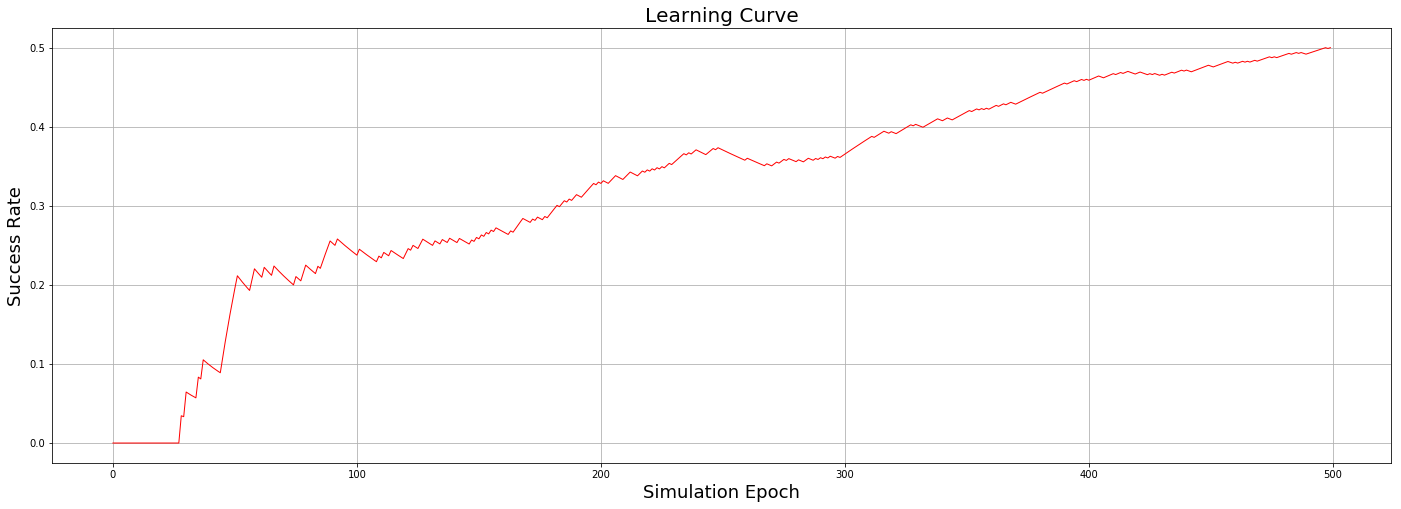

In [21]:
draw_learning_curve(curve)

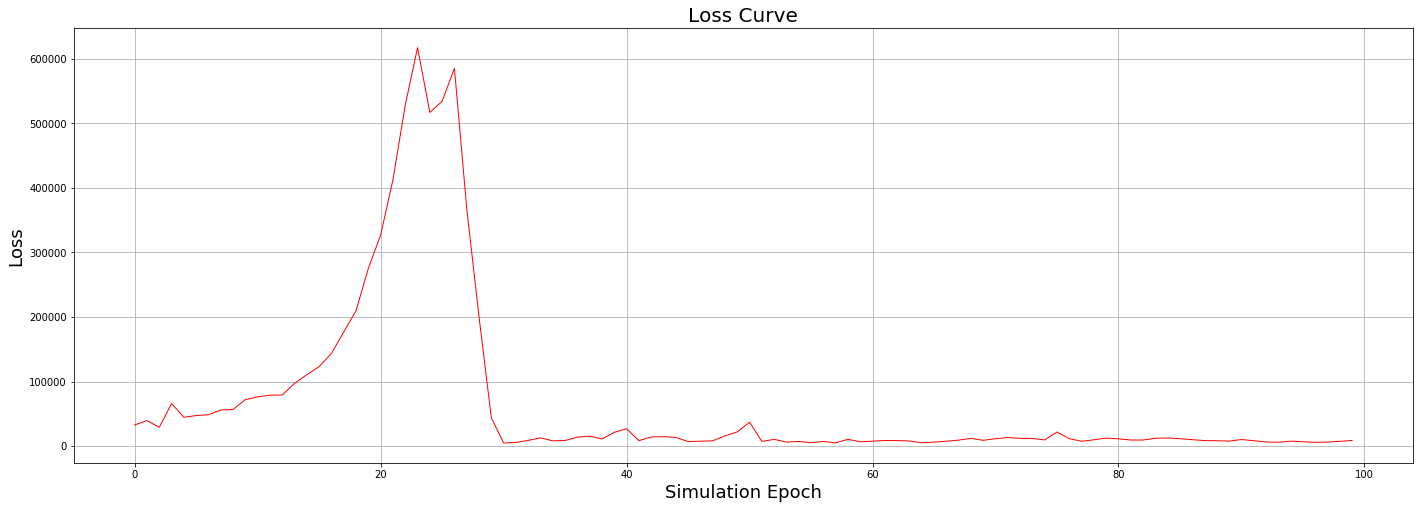

In [28]:
draw_loss_curve(losses)

In [ ]:
draw_loss_curve(losses[-100:])